In [1]:
import pickle
import xarray as xr
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import signal
from scipy.fftpack import fft, ifft
import numpy
import matplotlib.pyplot as plt

Here we evaluate the robustness of each of the 6 atmospheric inversion models to the Global Carbon Project observations.<br><br>
Note that GCP land flux = land (from DGVMs) + BIM (budget imbalance) which represents the residual flux. This keeps the analysis consistent with comparing models to observations (GCP).

In [2]:
# Models
CAMS = pd.read_csv("./../../../output/inversions/raw/output_CAMS.csv").set_index("Year")
CTRACKER = pd.read_csv("./../../../output/inversions/raw/output_CTRACKER.csv").set_index("Year")
Rayner = pd.read_csv("./../../../output/inversions/raw/output_Rayner.csv").set_index("Year")
JAMSTEC = pd.read_csv("./../../../output/inversions/raw/output_JAMSTEC.csv").set_index("Year")
JENA_s76 = pd.read_csv("./../../../output/inversions/raw/output_JENA_s76.csv").set_index("Year")
JENA_s85 = pd.read_csv("./../../../output/inversions/raw/output_JENA_s85.csv").set_index("Year")

In [3]:
#GCP
fGCB = './../../../data/GCP/budget.csv'
df = pd.read_csv(fGCB,
                 index_col=0,
                 usecols=[0,4,5],
                 skipfooter=1
                )
df.head()

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


,ocean sink,land sink
Year,,
1959,0.852376,1.376389
1960,0.819017,1.916752
1961,0.714842,1.818860
1962,0.756709,2.307954
1963,0.904997,2.233127


In [4]:
fCO2 = './../../../data/CO2/co2_global.csv'
CO2 = pd.read_csv(fCO2, index_col=0, header=0)[2:]
CO2.head()

,CO2
Year,
1959,315.486
1960,316.163
1961,316.856
1962,317.558
1963,318.268


In [5]:
df['CO2'] = CO2
df['land sink'] = -df['land sink']
df['ocean sink'] = -df['ocean sink']

df.head()

,ocean sink,land sink,CO2
Year,,,
1959,-0.852376,-1.376389,315.486
1960,-0.819017,-1.916752,316.163
1961,-0.714842,-1.818860,316.856
1962,-0.756709,-2.307954,317.558
1963,-0.904997,-2.233127,318.268


In [6]:
df.rename(columns={"ocean sink": "ocean", "land sink": "land"},
         inplace=True)
df.head()

,ocean,land,CO2
Year,,,
1959,-0.852376,-1.376389,315.486
1960,-0.819017,-1.916752,316.163
1961,-0.714842,-1.818860,316.856
1962,-0.756709,-2.307954,317.558
1963,-0.904997,-2.233127,318.268


# Functions

## Plots

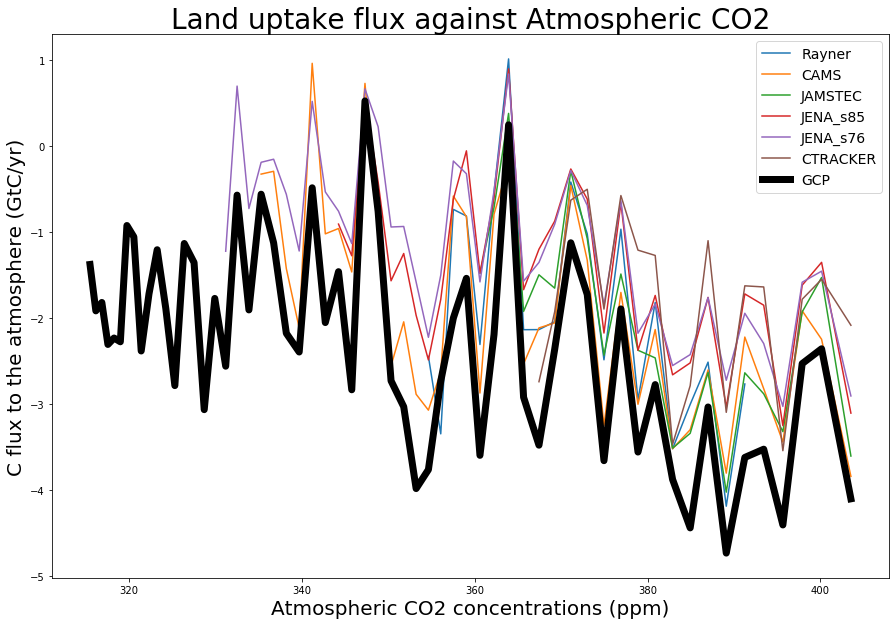

In [7]:
plt.figure(figsize=(15,10))

plt.plot(df.loc[1992:2012].CO2, Rayner.Earth_Land)
plt.plot(df.loc[1979:2017].CO2, CAMS.Earth_Land)
plt.plot(df.loc[1996:2017].CO2, JAMSTEC.Earth_Land)
plt.plot(df.loc[1985:2017].CO2, JENA_s85.Earth_Land)
plt.plot(df.loc[1976:2017].CO2, JENA_s76.Earth_Land)
plt.plot(df.loc[2000:2017].CO2, CTRACKER.Earth_Land)
plt.plot(df.CO2, df.land, linewidth=7, color='k')

plt.title("Land uptake flux against Atmospheric CO2", fontsize=28)
plt.xlabel("Atmospheric CO2 concentrations (ppm)", fontsize=20)
plt.ylabel("C flux to the atmosphere (GtC/yr)", fontsize=20)
plt.legend(["Rayner", "CAMS", "JAMSTEC", "JENA_s85", "JENA_s76", "CTRACKER", "GCP"], fontsize=14)

In [8]:
pickle.dump([df.CO2, df.land], open("./GCP_land.pik", "wb"))

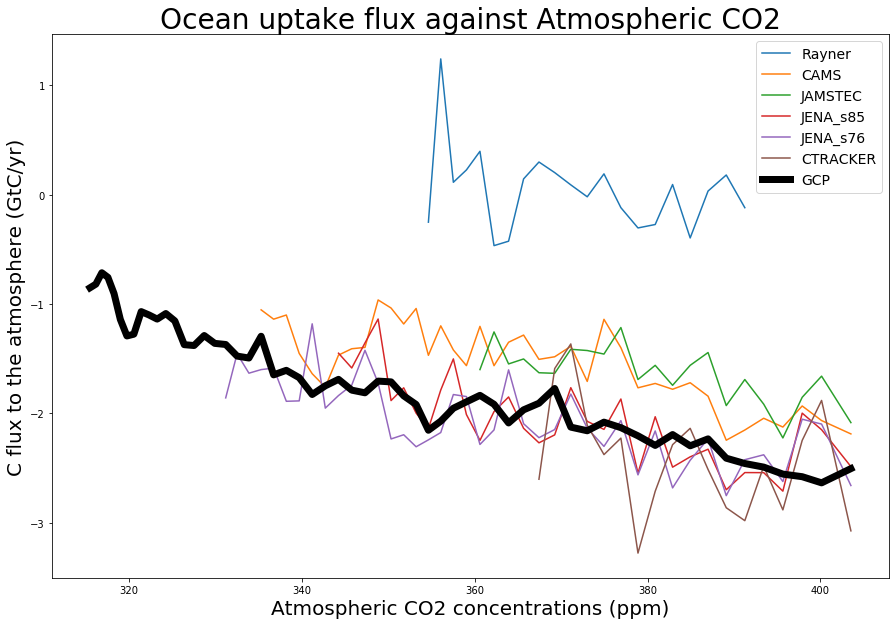

In [9]:
plt.figure(figsize=(15,10))

plt.plot(df.loc[1992:2012].CO2, Rayner.Earth_Ocean)
plt.plot(df.loc[1979:2017].CO2, CAMS.Earth_Ocean)
plt.plot(df.loc[1996:2017].CO2, JAMSTEC.Earth_Ocean)
plt.plot(df.loc[1985:2017].CO2, JENA_s85.Earth_Ocean)
plt.plot(df.loc[1976:2017].CO2, JENA_s76.Earth_Ocean)
plt.plot(df.loc[2000:2017].CO2, CTRACKER.Earth_Ocean)
plt.plot(df.CO2, df.ocean, linewidth=7, color='k')

plt.title("Ocean uptake flux against Atmospheric CO2", fontsize=28)
plt.xlabel("Atmospheric CO2 concentrations (ppm)", fontsize=20)
plt.ylabel("C flux to the atmosphere (GtC/yr)", fontsize=20)
plt.legend(["Rayner", "CAMS", "JAMSTEC", "JENA_s85", "JENA_s76", "CTRACKER", "GCP"], fontsize=14)

In [10]:
pickle.dump([df.CO2, df.ocean], open("./GCP_ocean.pik", "wb"))

## Global Uptake timeseries

In [11]:
GCB = df; GCB.head()

,ocean,land (model),land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [12]:
def model_GCP_timeseries(model, GCB_sink):
    
    if "land" in GCB_sink:
        model_sink = "Earth_Land"
    elif "ocean" in GCB_sink:
        model_sink = "Earth_Ocean"
    
    plt.figure(figsize=(14,9))
    plt.subplot(211).plot(model.index, GCB.loc[model.index][GCB_sink])
    plt.subplot(211).plot(model[model_sink])
    plt.legend(["GCP", "model"])
    plt.subplot(212).scatter(GCB.loc[model.index][GCB_sink], model[model_sink])
    
    return stats.linregress(GCB.loc[model.index][GCB_sink], model[model_sink])

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


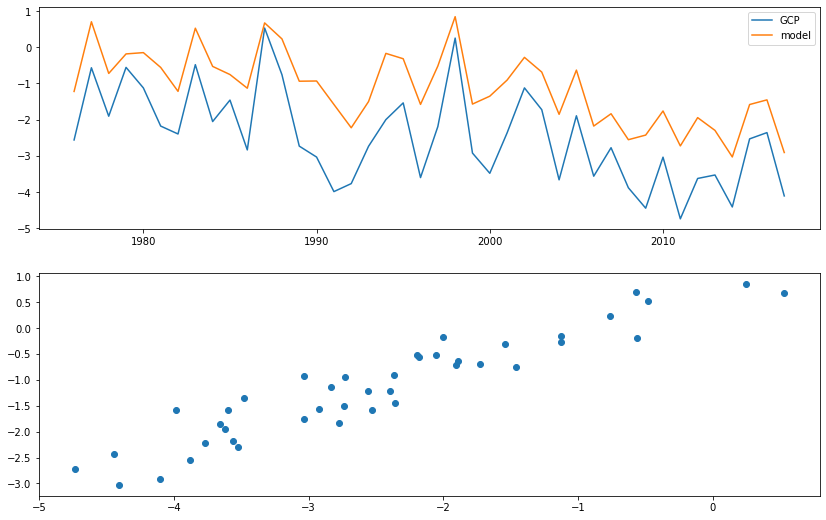

In [13]:
model_GCP_timeseries(JENA_s76 , "land");

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


LinregressResult(slope=0.7654909291344756, intercept=0.7449810716426817, rvalue=0.7632484567409027, pvalue=4.173736814427203e-09, stderr=0.10245833257091637)

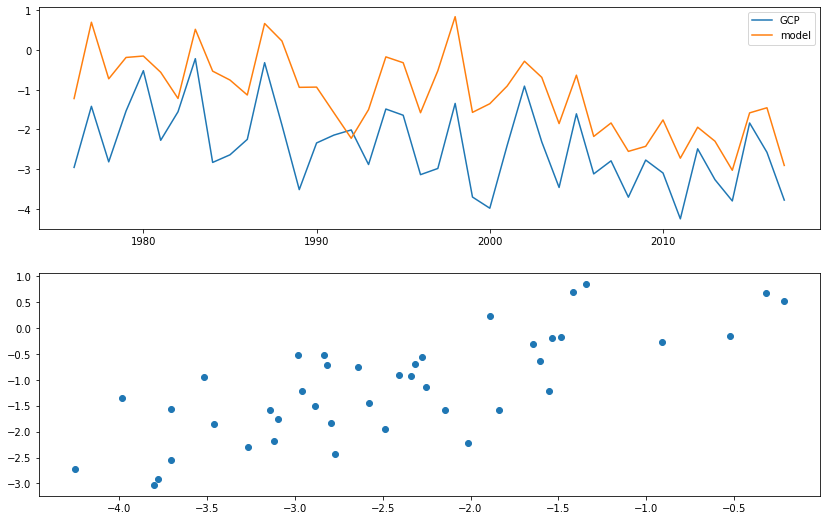

In [14]:
model_GCP_timeseries(JENA_s76 , "land (model)")

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


LinregressResult(slope=0.6108813106727659, intercept=-0.28207379937717403, rvalue=0.6188491638241481, pvalue=0.002136703683655757, stderr=0.17338385839363546)

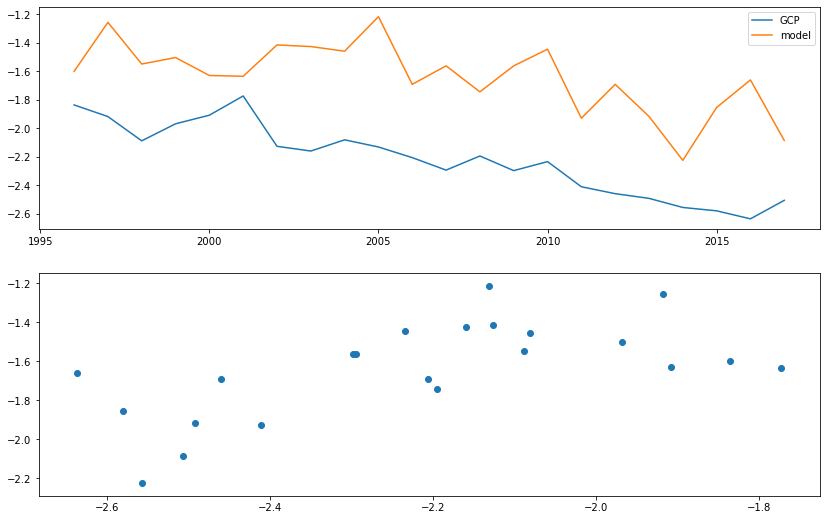

In [15]:
model_GCP_timeseries(JAMSTEC, "ocean")

## Rolling gradient

In [16]:
def get_fname(model, sink, window=10):
    return f"./../../../output/inversions/analysis/year/{model}/{sink}/rolling_trend_{window}_{sink}.pik"

In [17]:
get_fname("CAMS", "Earth_Land")

'./../../../output/inversions/analysis/year/CAMS/Earth_Land/rolling_trend_10_Earth_Land.pik'

In [18]:
CAMS_roll_land = pickle.load(open(get_fname("CAMS", "Earth_Land"), "rb"))["10-year trend slope"]

In [19]:
GCP_roll_land = pickle.load(open("./../../../output/GCP/rolling_trend/roll_df_land.pik", "rb"))["10-year trend slope"]

In [20]:
GCP_roll_ocean = pickle.load(open("./../../../output/GCP/rolling_trend/roll_df_land.pik", "rb"))["10-year trend slope"]

In [21]:
GCP_roll = pd.DataFrame({"Earth_Land": GCP_roll_land.values, "Earth_Ocean": GCP_roll_ocean.values}, index=GCP_roll_land.index)
GCP_roll.head()

,Earth_Land,Earth_Ocean
Year,,
1959,0.047010,0.047010
1960,0.057761,0.057761
1961,-0.012407,-0.012407
1962,0.032807,0.032807
1963,0.027451,0.027451


In [22]:
def model_GCP_rolling_trend(model_df, GCP_df):
    
    plt.figure(figsize=(14,9))
    
    
    
    plt.subplot(211).plot(index, GCP_df.loc[index])
    plt.subplot(211).plot(model_df)
    plt.legend(["GCP", "model"])
    plt.subplot(212).scatter(GCP_df.loc[index], model_df)
    
    return stats.linregress(GCP_df.loc[index].values.squeeze(), model_df.values.squeeze())

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


LinregressResult(slope=1.4630985950802256, intercept=-0.011548016056943791, rvalue=0.945154459413086, pvalue=1.2140914749001861e-14, stderr=0.09730533020742242)

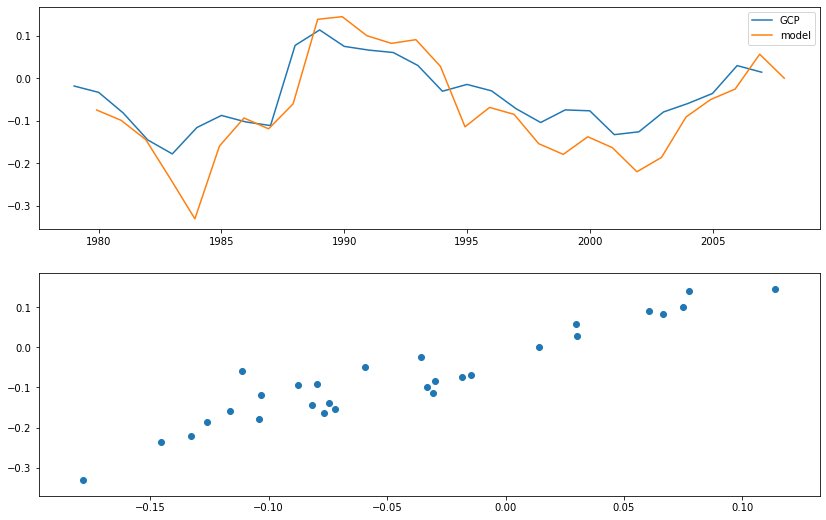

In [23]:
model_GCP_rolling_trend(CAMS_roll_land, GCP_roll_land)

In [24]:
def roll_open_model_and_evaluate(model, sink):
    model_to_evaluate = pickle.load(open(get_fname(model, sink), "rb"))
    return model_GCP_rolling_trend(model_to_evaluate, GCP_roll[sink])

In [25]:
roll_open_model_and_evaluate("JENA_s85", "land")

FileNotFoundError: [Errno 2] No such file or directory: './../../../output/inversions/analysis/year/JENA_s85/land/rolling_trend_10_land.pik'

In [26]:
roll_open_model_and_evaluate("CTRACKER", "ocean")

FileNotFoundError: [Errno 2] No such file or directory: './../../../output/inversions/analysis/year/CTRACKER/ocean/rolling_trend_10_ocean.pik'

COMMENTS: All land models correlate well with GCP land, but ocean is poorly correlated.

## Frequency spectrum & other statistical analyses

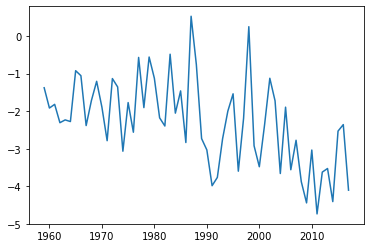

In [27]:
plt.plot(GCB["land"])

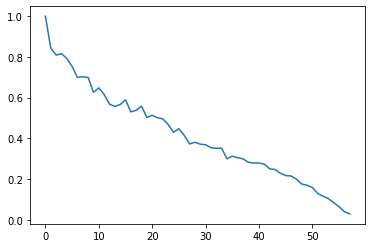

In [28]:
auto_cor = signal.correlate(GCB["land"], GCB["land"])
halfway_index = int((len(auto_cor)+1)/2)-1
plt.plot(auto_cor[halfway_index:-1]/auto_cor[halfway_index])

Other things to do:
- Frequency correlation
- Cross-correlation
- Refer to stats course (sem 1) for more things to do

In [29]:
def power_spec(N, T, y):
    """
    N = no. of sample points.
    T = sample spacing.
    """
    x = np.linspace(0, N*T, N)
    xf = np.linspace(0, 1.0/(2.*T), N//2)
    yf = fft(y)
    y_plot = 2.0/N * np.abs(yf[0:N//2])
    
    df = (pd
          .DataFrame({"Frequency (1/year)": xf[1:],
                      "Time Period (year)": 1/(xf[1:]),
                      "Spectral Variance (GtC)^2.yr": y_plot[1:]
                     }
                    )
          .set_index("Frequency (1/year)")
         )
    
    plt.semilogy(df["Spectral Variance (GtC)^2.yr"])
    plt.xlabel("Frequency (1/year)")
    plt.ylabel("Spectral Variance (GtC)^2.yr")
    
    return df


In [30]:
power_spec(59,1,np.sin(x))

NameError: name 'x' is not defined

,Time Period (year),Spectral Variance (GtC)^2.yr
Frequency (1/year),,
0.017857,56.000000,0.798037
0.035714,28.000000,0.300459
0.053571,18.666667,0.583986
0.071429,14.000000,0.171488
0.089286,11.200000,0.066873
0.107143,9.333333,0.307266
0.125000,8.000000,0.286570
0.142857,7.000000,0.247804
0.160714,6.222222,0.074460


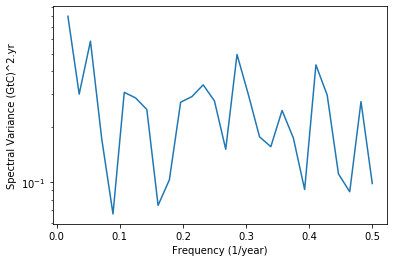

In [31]:
power_spec(59,1,GCB["land"])

In [32]:
from pandas.plotting import lag_plot, autocorrelation_plot
from pandas import concat

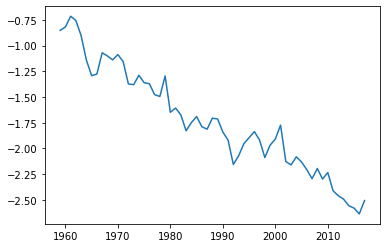

In [33]:
plt.plot(GCB["ocean"])

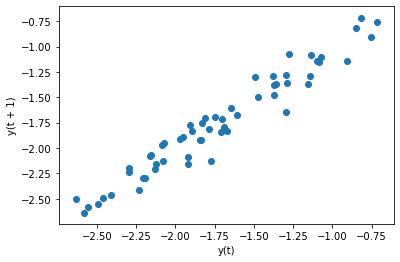

In [34]:
lag_plot(GCB["ocean"])

In [35]:
dataframe = concat([GCB["ocean"].shift(1), GCB["ocean"]], axis=1)
dataframe.columns = ['t-1', 't+1']
dataframe.corr()

,t-1,t+1
t-1,1.000000,0.971188
t+1,0.971188,1.000000


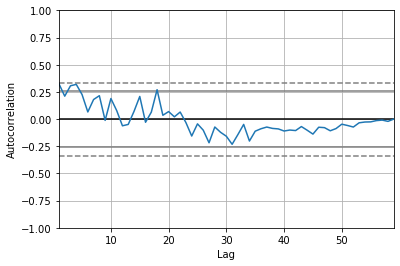

In [36]:
autocorrelation_plot(GCB["land"])

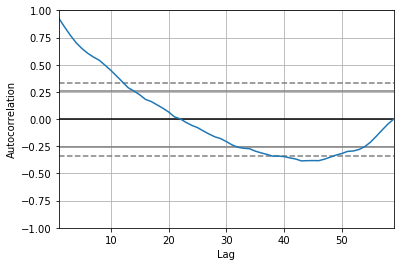

In [37]:
autocorrelation_plot(GCB["ocean"])

## Model eval of long-term trend slopes

In [38]:
def model_GCP_trend(model, GCB_sink):
    
    if "land" in GCB_sink:
        model_sink = "Earth_Land"
    elif "ocean" in GCB_sink:
        model_sink = "Earth_Ocean"
    
    GCP_stats = stats.linregress(model.index, GCB.loc[model.index][GCB_sink])
    model_stats = stats.linregress(model.index, model[model_sink])
    
    plt.bar(["GCP", "model"], [GCP_stats[0], model_stats[0]])
    
    print(f"GCP slope: {GCP_stats[0]*1e3:.3f} MtC/yr",
          f"Model slope: {model_stats[0]*1e3:.3f} MtC/yr",
          f"Percentage difference: {((GCP_stats[0]*100/model_stats[0])-100):.2f}%", sep="\n")

GCP slope: -78.948 MtC/yr
Model slope: -46.397 MtC/yr
Percentage difference: 70.16%


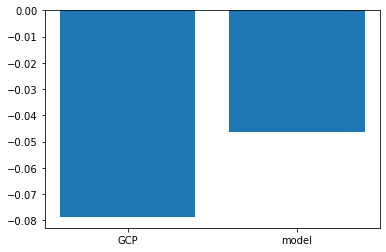

In [39]:
model_GCP_trend(CTRACKER, "land")

GCP slope: -41.605 MtC/yr
Model slope: -36.965 MtC/yr
Percentage difference: 12.55%


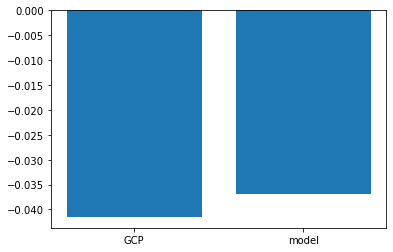

In [40]:
model_GCP_trend(CTRACKER, "ocean")

GCP slope: -62.806 MtC/yr
Model slope: -64.610 MtC/yr
Percentage difference: -2.79%


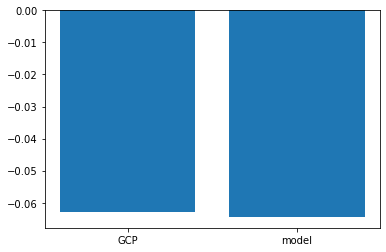

In [41]:
model_GCP_trend(CAMS, "land")

GCP slope: -25.596 MtC/yr
Model slope: -23.429 MtC/yr
Percentage difference: 9.25%


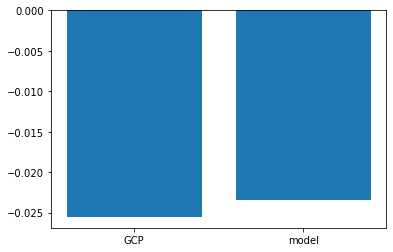

In [42]:
model_GCP_trend(CAMS, "ocean")

GCP slope: -21.910 MtC/yr
Model slope: -19.257 MtC/yr
Percentage difference: 13.78%


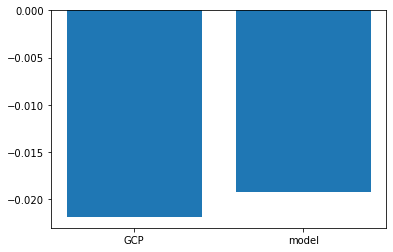

In [43]:
model_GCP_trend(Rayner, "ocean")

GCP slope: -36.415 MtC/yr
Model slope: -25.406 MtC/yr
Percentage difference: 43.33%


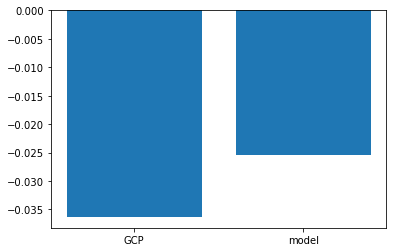

In [44]:
model_GCP_trend(JAMSTEC, "ocean")

GCP slope: -26.247 MtC/yr
Model slope: -31.047 MtC/yr
Percentage difference: -15.46%


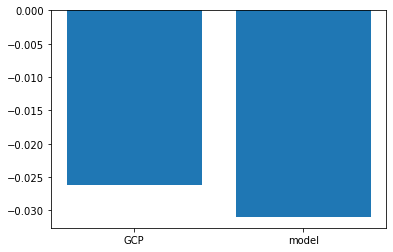

In [45]:
model_GCP_trend(JENA_s85, "ocean")

# Integrate to INVF

In [46]:
import sys
sys.path.append("./../../../scripts/core")
import inv_flux as invf

In [47]:
from importlib import reload
reload(invf)

<module 'inv_flux' from './../../../scripts/core\\inv_flux.py'>

In [48]:
data = pickle.load(open("./../../../output/inversions/raw/output_all/CTRACKER_all/year.pik", "rb"))

In [49]:
invf.ModelEvaluation(data)

FileNotFoundError: [Errno 2] File b'./../../data/GCP/budget.csv' does not exist: b'./../../data/GCP/budget.csv'

In [50]:
invf.ModelEvaluation(data).plot_vs_GCP("Earth_Land", "land", "CO2")

FileNotFoundError: [Errno 2] File b'./../../data/GCP/budget.csv' does not exist: b'./../../data/GCP/budget.csv'

In [51]:
invf.ModelEvaluation(data).compare_trend_to_GCP("ocean")

FileNotFoundError: [Errno 2] File b'./../../data/GCP/budget.csv' does not exist: b'./../../data/GCP/budget.csv'

In [52]:
autocorrelation_plot(invf.ModelEvaluation(data).data.Earth_Land.values)

FileNotFoundError: [Errno 2] File b'./../../data/GCP/budget.csv' does not exist: b'./../../data/GCP/budget.csv'

In [53]:
invf.ModelEvaluation(data).autocorrelation_plot("Earth_Ocean")

FileNotFoundError: [Errno 2] File b'./../../data/GCP/budget.csv' does not exist: b'./../../data/GCP/budget.csv'

In [54]:
invf.Analysis(data).rolling_trend("Earth_Land")

,25-year trend slope


In [55]:
type(invf.Analysis(data).data.time.values[0]).year

<attribute 'year' of 'cftime._cftime.datetime' objects>